# Character level text generation using LSTM

This notebook is based on the programming assignment of deeplearning.ai, course Sequence Models, week Recurrent Neural Networks. The figures are also taken from that assignment.

We will build a character-level text generation LSTM network to generate new dinosaur names.

## Learning objectives

- Application of Long short-term memory (LSTM) neural network in TensorFlow
- Use of Adam optimizer 
- Use gradient clipping
- Use variable length sequences in TensorFlow
- Apply padding to make all sequences have the same length
- Use of GPU for the training of the model

In [2]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.14.0


In [3]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [4]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n" (or newline character), which in this assignment plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture, only here it indicates the end of the dinosaur name rather than the end of a sentence. In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, `char_to_ix` and `ix_to_char` are the python dictionaries. 

In [5]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print(ix_to_char)
print(char_to_ix)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
{'v': 22, 's': 19, 'r': 18, 'y': 25, 'j': 10, 'w': 23, 'q': 17, 'f': 6, 't': 20, 'k': 11, 'h': 8, 'u': 21, 'x': 24, 'g': 7, 'e': 5, '\n': 0, 'd': 4, 'c': 3, 'n': 14, 'i': 9, 'm': 13, 'a': 1, 'o': 15, 'z': 26, 'p': 16, 'l': 12, 'b': 2}


In [6]:
data

'aachenosaurus\naardonyx\nabdallahsaurus\nabelisaurus\nabrictosaurus\nabrosaurus\nabydosaurus\nacanthopholis\nachelousaurus\nacheroraptor\nachillesaurus\nachillobator\nacristavus\nacrocanthosaurus\nacrotholus\nactiosaurus\nadamantisaurus\nadasaurus\nadelolophus\nadeopapposaurus\naegyptosaurus\naeolosaurus\naepisaurus\naepyornithomimus\naerosteon\naetonyxafromimus\nafrovenator\nagathaumas\naggiosaurus\nagilisaurus\nagnosphitys\nagrosaurus\nagujaceratops\nagustinia\nahshislepelta\nairakoraptor\najancingenia\najkaceratops\nalamosaurus\nalaskacephale\nalbalophosaurus\nalbertaceratops\nalbertadromeus\nalbertavenator\nalbertonykus\nalbertosaurus\nalbinykus\nalbisaurus\nalcovasaurus\nalectrosaurus\naletopelta\nalgoasaurus\nalioramus\naliwalia\nallosaurus\nalmas\nalnashetri\nalocodon\naltirhinus\naltispinax\nalvarezsaurus\nalwalkeria\nalxasaurus\namargasaurus\namargastegos\namargatitanis\namazonsaurus\nammosaurus\nampelosaurus\namphicoelias\namphicoelicaudia\namphisaurus\namtocephale\namtosaur

In [7]:
names = data.split('\n')

In [8]:
names

['aachenosaurus',
 'aardonyx',
 'abdallahsaurus',
 'abelisaurus',
 'abrictosaurus',
 'abrosaurus',
 'abydosaurus',
 'acanthopholis',
 'achelousaurus',
 'acheroraptor',
 'achillesaurus',
 'achillobator',
 'acristavus',
 'acrocanthosaurus',
 'acrotholus',
 'actiosaurus',
 'adamantisaurus',
 'adasaurus',
 'adelolophus',
 'adeopapposaurus',
 'aegyptosaurus',
 'aeolosaurus',
 'aepisaurus',
 'aepyornithomimus',
 'aerosteon',
 'aetonyxafromimus',
 'afrovenator',
 'agathaumas',
 'aggiosaurus',
 'agilisaurus',
 'agnosphitys',
 'agrosaurus',
 'agujaceratops',
 'agustinia',
 'ahshislepelta',
 'airakoraptor',
 'ajancingenia',
 'ajkaceratops',
 'alamosaurus',
 'alaskacephale',
 'albalophosaurus',
 'albertaceratops',
 'albertadromeus',
 'albertavenator',
 'albertonykus',
 'albertosaurus',
 'albinykus',
 'albisaurus',
 'alcovasaurus',
 'alectrosaurus',
 'aletopelta',
 'algoasaurus',
 'alioramus',
 'aliwalia',
 'allosaurus',
 'almas',
 'alnashetri',
 'alocodon',
 'altirhinus',
 'altispinax',
 'alvarez

convert each name to list of indices, by converting each character to the corresponding index

In [9]:
names_ints = []
for each in names:
    names_ints.append([char_to_ix[word] for word in each])

In [10]:
from collections import Counter
names_lens = Counter([len(x) for x in names_ints])
print("Maximum name length: {}".format(max(names_lens)))

Maximum name length: 26


In [11]:
names_lens

Counter({3: 1,
         4: 5,
         5: 7,
         6: 13,
         7: 22,
         8: 73,
         9: 94,
         10: 191,
         11: 232,
         12: 268,
         13: 269,
         14: 148,
         15: 104,
         16: 64,
         17: 22,
         18: 13,
         19: 3,
         20: 2,
         21: 1,
         23: 2,
         25: 1,
         26: 1})

TensorFlow unfolds our recurrent network for a given number of steps. Assuming each character of each name corresponds to one time step, each input, even within the same batch, will have variable lengths. Thus, we need to specify a maximum sequence length and pad all shorter sequences.

Since the dinosaur names have variable lengths we will pad shorter names, so all names have same lengths. We will pad the missing characters with -1. We pad with -1, because in this case tf.one_hot(self.inputs, num_classes) will give 0s for the -1. We want to use one-hot vectors for the actual characters    

The longest dinosaur name is 26 characters (i.e. time steps). I set the recurrent network to have 30 time steps (seq_len=30)

The first entry of features_x being -1 will be interpreted (when we do one-hot encoding) as setting  $x^{\langle 0 \rangle} = \vec{0}$. Further, this ensures that features_y is equal to features_x but shifted one step to the left, and with an additional "\n" appended to signify the end of the dinosaur name.

In [12]:
seq_len=30
features_x = np.ones((len(names_ints), seq_len), dtype=int)*(-1)
features_y = np.ones((len(names_ints), seq_len), dtype=int)*(-1)
for i, row in enumerate(names_ints):
    features_x[i, 1:len(row)+1] = np.array(row) # the first entry in each row of features_x is -1  
    features_y[i, :len(row)] = np.array(row)
    features_y[i, len(row):len(row)+1]=char_to_ix['\n']
    # features_y is equal to features_x but shifted one step 
    # to the left, and with an additional "\n" appended to signify the end of the dinosaur name
    
    # I had before features_x[i, 1:len(row)+1] = np.array(row)[:seq_len] and features_y[i, :len(row)] = np.array(row)[:seq_len] 

In [13]:
def get_batches(x, y, batch_size):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

code taken from https://danijar.com/variable-sequence-lengths-in-tensorflow/

We compute the sequence lengths (lengths of input dinosaur names wihtout padding). We assume that the sequences are padded with -1 to fill up the remaining time steps in the batch

We want to know the length (without padding) of the input sequence, so that the output of the LSTM cells corresponding to the padded time steps is 0. Since, the first character of the input is set to -1, we need to add an 1 to the line length = tf.reduce_sum(used, 1)+1

The function returns a vector of size batch_size, which gives the length for each sequence in the batch

In [14]:
def length(sequence):   
  used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
  length = tf.reduce_sum(used, 1)+1 #we add 1 to account for the fact that we start with a zeroth pad
  length = tf.cast(length, tf.int32)
  return length

In [15]:
def build_inputs(batch_size, num_steps):
    
    inputs = tf.placeholder(tf.int32,[batch_size,num_steps],name='inputs')
    targets = tf.placeholder(tf.int32,[batch_size,num_steps], name='targets')
    
    return inputs, targets

In [16]:
def build_lstm(lstm_size, lstm_layers, batch_size):
    
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([lstm for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

In [17]:
def build_output(lstm_output, in_size, out_size):
    
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,lstm_size]) # i think lstm_size should be replaced with in_size
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal([in_size, out_size]))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.add(tf.matmul(x,softmax_w),softmax_b)
    
    # Use softmax to get the probabilities for predicted characters
    predictions = tf.nn.softmax(logits)     

    return predictions, logits

In [18]:
def build_loss(logits, targets, lstm_size, num_classes):
    
    y_one_hot = tf.one_hot(targets, depth=num_classes)
    y_reshaped = tf.reshape(y_one_hot,[-1,num_classes])
    
    # Softmax cross entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))
    

    return loss

In [19]:
def build_optimizer(loss, learning_rate, grad_clip):
    
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [20]:
class CharRNN:
    
    def __init__(self, num_classes=vocab_size, batch_size=10, num_steps=seq_len, 
                       lstm_size=128, lstm_layers=1, learning_rate=0.01, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.targets = build_inputs(batch_size, num_steps)
        
        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, lstm_layers, batch_size)
            
        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        inputs_one_hot = tf.one_hot(self.inputs, num_classes)
                
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state = tf.nn.dynamic_rnn(cell ,inputs_one_hot, sequence_length=length(inputs_one_hot), 
                                           initial_state=self.initial_state)
        self.final_state = state

        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)   

In [21]:
batch_size = 10        # Sequences per batch
num_steps = seq_len    # Number of sequence steps per batch
lstm_size = 128         # Size of hidden layers in LSTMs
lstm_layers = 1          # Number of LSTM layers
learning_rate = 0.01    # Learning rate
grad_clip=5
num_classes=vocab_size

In [22]:
epochs = 230

model = CharRNN(vocab_size, batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, lstm_layers=lstm_layers, 
                learning_rate=learning_rate)


saver = tf.train.Saver(max_to_keep=10000) 


loss_vec = []
with tf.Session(config=config) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    iteration = 0
    
    
    start_time=time.time()
    for e in range(epochs):
        
        state = sess.run(model.initial_state) 
        
        for ii, (x, y) in enumerate(get_batches(features_x, features_y, batch_size), 1):
            feed = {model.inputs: x,
                    model.targets: y,
                    model.initial_state: state}
            batch_loss, state, _, initial_state_val = sess.run([model.loss,                                    
                                        model.final_state,model.optimizer,model.initial_state],
                                         feed_dict=feed)
            
            loss_vec.append(batch_loss)
           
            
            if iteration%50==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(batch_loss))
            
            # we save checkpoints that we will use to perform the sampling
            if (iteration % 2000 == 0):
                saver.save(sess, "checkpoints/i{}.ckpt".format(iteration))
                
            iteration +=1
            
    
    duration=time.time()-start_time
    print("duration: {:.1f} sec".format(duration))
    saver.save(sess, "checkpoints/i{}.ckpt".format(iteration))

W0815 03:18:29.030048 21396 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 03:18:29.030048 21396 deprecation.py:323] From <ipython-input-16-21b64da84c03>:4: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0815 03:18:29.031014 21396 deprecation.py:323] From <ipython-input-16-21b64da84c03>:7: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is e

Epoch: 1/230 Iteration: 0 Train loss: 1.430
Epoch: 1/230 Iteration: 50 Train loss: 1.198
Epoch: 1/230 Iteration: 100 Train loss: 1.183
Epoch: 1/230 Iteration: 150 Train loss: 0.900
Epoch: 2/230 Iteration: 200 Train loss: 0.830
Epoch: 2/230 Iteration: 250 Train loss: 0.896
Epoch: 2/230 Iteration: 300 Train loss: 0.836
Epoch: 3/230 Iteration: 350 Train loss: 0.583
Epoch: 3/230 Iteration: 400 Train loss: 0.781
Epoch: 3/230 Iteration: 450 Train loss: 0.863
Epoch: 4/230 Iteration: 500 Train loss: 0.826
Epoch: 4/230 Iteration: 550 Train loss: 0.651
Epoch: 4/230 Iteration: 600 Train loss: 0.734
Epoch: 5/230 Iteration: 650 Train loss: 0.748
Epoch: 5/230 Iteration: 700 Train loss: 0.651
Epoch: 5/230 Iteration: 750 Train loss: 0.508
Epoch: 6/230 Iteration: 800 Train loss: 0.622
Epoch: 6/230 Iteration: 850 Train loss: 0.651
Epoch: 6/230 Iteration: 900 Train loss: 0.696
Epoch: 7/230 Iteration: 950 Train loss: 0.577
Epoch: 7/230 Iteration: 1000 Train loss: 0.616
Epoch: 7/230 Iteration: 1050 Train l

Epoch: 57/230 Iteration: 8600 Train loss: 0.323
Epoch: 57/230 Iteration: 8650 Train loss: 0.329
Epoch: 57/230 Iteration: 8700 Train loss: 0.317
Epoch: 58/230 Iteration: 8750 Train loss: 0.344
Epoch: 58/230 Iteration: 8800 Train loss: 0.302
Epoch: 58/230 Iteration: 8850 Train loss: 0.269
Epoch: 59/230 Iteration: 8900 Train loss: 0.273
Epoch: 59/230 Iteration: 8950 Train loss: 0.327
Epoch: 59/230 Iteration: 9000 Train loss: 0.279
Epoch: 60/230 Iteration: 9050 Train loss: 0.314
Epoch: 60/230 Iteration: 9100 Train loss: 0.264
Epoch: 60/230 Iteration: 9150 Train loss: 0.278
Epoch: 61/230 Iteration: 9200 Train loss: 0.302
Epoch: 61/230 Iteration: 9250 Train loss: 0.270
Epoch: 61/230 Iteration: 9300 Train loss: 0.253
Epoch: 62/230 Iteration: 9350 Train loss: 0.285
Epoch: 62/230 Iteration: 9400 Train loss: 0.260
Epoch: 62/230 Iteration: 9450 Train loss: 0.354
Epoch: 63/230 Iteration: 9500 Train loss: 0.248
Epoch: 63/230 Iteration: 9550 Train loss: 0.280
Epoch: 63/230 Iteration: 9600 Train loss

Epoch: 112/230 Iteration: 17000 Train loss: 0.301
Epoch: 112/230 Iteration: 17050 Train loss: 0.301
Epoch: 112/230 Iteration: 17100 Train loss: 0.278
Epoch: 113/230 Iteration: 17150 Train loss: 0.231
Epoch: 113/230 Iteration: 17200 Train loss: 0.298
Epoch: 113/230 Iteration: 17250 Train loss: 0.273
Epoch: 114/230 Iteration: 17300 Train loss: 0.251
Epoch: 114/230 Iteration: 17350 Train loss: 0.243
Epoch: 114/230 Iteration: 17400 Train loss: 0.226
Epoch: 115/230 Iteration: 17450 Train loss: 0.221
Epoch: 115/230 Iteration: 17500 Train loss: 0.215
Epoch: 115/230 Iteration: 17550 Train loss: 0.257
Epoch: 116/230 Iteration: 17600 Train loss: 0.264
Epoch: 116/230 Iteration: 17650 Train loss: 0.233
Epoch: 116/230 Iteration: 17700 Train loss: 0.248
Epoch: 117/230 Iteration: 17750 Train loss: 0.344
Epoch: 117/230 Iteration: 17800 Train loss: 0.263
Epoch: 117/230 Iteration: 17850 Train loss: 0.246
Epoch: 117/230 Iteration: 17900 Train loss: 0.201
Epoch: 118/230 Iteration: 17950 Train loss: 0.250


Epoch: 165/230 Iteration: 25200 Train loss: 0.239
Epoch: 166/230 Iteration: 25250 Train loss: 0.232
Epoch: 166/230 Iteration: 25300 Train loss: 0.211
Epoch: 166/230 Iteration: 25350 Train loss: 0.252
Epoch: 167/230 Iteration: 25400 Train loss: 0.279
Epoch: 167/230 Iteration: 25450 Train loss: 0.219
Epoch: 167/230 Iteration: 25500 Train loss: 0.222
Epoch: 167/230 Iteration: 25550 Train loss: 0.159
Epoch: 168/230 Iteration: 25600 Train loss: 0.225
Epoch: 168/230 Iteration: 25650 Train loss: 0.268
Epoch: 168/230 Iteration: 25700 Train loss: 0.243
Epoch: 169/230 Iteration: 25750 Train loss: 0.223
Epoch: 169/230 Iteration: 25800 Train loss: 0.258
Epoch: 169/230 Iteration: 25850 Train loss: 0.253
Epoch: 170/230 Iteration: 25900 Train loss: 0.243
Epoch: 170/230 Iteration: 25950 Train loss: 0.174
Epoch: 170/230 Iteration: 26000 Train loss: 0.194
Epoch: 171/230 Iteration: 26050 Train loss: 0.199
Epoch: 171/230 Iteration: 26100 Train loss: 0.250
Epoch: 171/230 Iteration: 26150 Train loss: 0.179


Epoch: 219/230 Iteration: 33400 Train loss: 0.241
Epoch: 219/230 Iteration: 33450 Train loss: 0.264
Epoch: 219/230 Iteration: 33500 Train loss: 0.215
Epoch: 220/230 Iteration: 33550 Train loss: 0.233
Epoch: 220/230 Iteration: 33600 Train loss: 0.174
Epoch: 220/230 Iteration: 33650 Train loss: 0.201
Epoch: 221/230 Iteration: 33700 Train loss: 0.206
Epoch: 221/230 Iteration: 33750 Train loss: 0.240
Epoch: 221/230 Iteration: 33800 Train loss: 0.195
Epoch: 222/230 Iteration: 33850 Train loss: 0.200
Epoch: 222/230 Iteration: 33900 Train loss: 0.152
Epoch: 222/230 Iteration: 33950 Train loss: 0.238
Epoch: 223/230 Iteration: 34000 Train loss: 0.206
Epoch: 223/230 Iteration: 34050 Train loss: 0.179
Epoch: 223/230 Iteration: 34100 Train loss: 0.207
Epoch: 224/230 Iteration: 34150 Train loss: 0.212
Epoch: 224/230 Iteration: 34200 Train loss: 0.247
Epoch: 224/230 Iteration: 34250 Train loss: 0.210
Epoch: 225/230 Iteration: 34300 Train loss: 0.258
Epoch: 225/230 Iteration: 34350 Train loss: 0.251


## Plot training loss

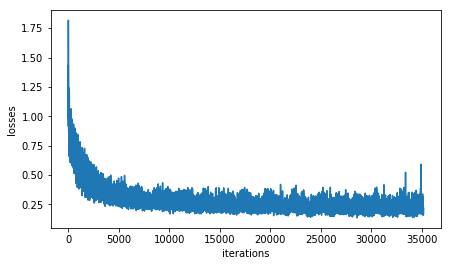

In [23]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1,iteration+1), loss_vec)
plt.ylabel('losses')
plt.xlabel('iterations')
plt.show()

## Sampling
Now that our model is trained we would like to generate new text (characters). The process is explained in the figure below:
<img src="images/dinos3.png" style="width:500;height:300px;">
Assuming the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time step and have the network then sample one character at a time. </center></caption>

In [24]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

In [25]:
def sample(checkpoint,lstm_size, vocab_size):
    
    samples = []
    model = CharRNN(num_classes=vocab_size, lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
        
    with tf.Session(config=config) as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state) 

        x = np.zeros((1, 1))
        x[0,0] = -1
        feed = {model.inputs: x,
                model.initial_state: new_state}
        preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)
        
                
        c = pick_top_n(preds, vocab_size)
        samples.append(ix_to_char[c])
        counter=1

        
        #for i in range(n_samples):
        while (c != char_to_ix['\n'] and counter != num_steps):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, vocab_size)
            samples.append(ix_to_char[c])
        
            counter +=1
            
        if (counter == num_steps):
            samples.append('\n')
           
            
    return ''.join(samples)

### After a few thousand iterations the model learns to generate reasonable-looking names 

In [26]:
dino_names = 7 # we will print 7 dinosaur names for each checkpoints

for kkk in range(0, iteration, 2000):
    checkpoint = 'checkpoints/i'+str(kkk)+'.ckpt'
    print('iteration: '+str(kkk)+'\n')
    for name in range(dino_names):
        samp = sample(checkpoint,lstm_size, vocab_size)
        print(samp)
    print('--------------\n')

iteration: 0



W0815 03:28:46.507583 21396 deprecation.py:323] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


rel

s

rausarsuauuaass

rusauussuauassuuass

russ

s

aaaalllsspusasrsauas

--------------

iteration: 2000

rinhonia

inoceratops

ingonioraus

entosaurus

onosaurus

epellosaurus

eocephale

--------------

iteration: 4000

achillisaurus

inornis

alinosaurus

anchiaravadon

illusaurus

achiosaurus

inornit

--------------

iteration: 6000

archaeodontosaurus

acanthopholis

ankistafima

arapasaurus

argastadromaeus

oreatosaurus

aleoraptor

--------------

iteration: 8000

aciliatrus

euceratops

achelousaurus

achelousaurus

arinosaurus

atianmbisaurus

acanthopholig

--------------

iteration: 10000

rionosaurus

echinodon

achelousaurus

archaeornis

echinodon

ongosaurus

acanthopholis

--------------

iteration: 12000

reptospondylus

onatitan

abrazanontryonzhosaurus

achisaurus

archaeodontos

alberzapalops

anabiserops

--------------

iteration: 14000

abelisaurus

isceiysaurus

rachiantosaurus

archaeoraptor

anchiornis

abelisaurus

acanthophalesus

--------------

iter

### The dinosaur names generated at the last checkpoint

In [27]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
for name in range(dino_names):
    samp = sample(checkpoint,lstm_size, vocab_size)
    print(samp)

rhodongosaurus

rocoraptor

archaeornithoides

anchiovenator

achelousaurus

oraptor

linhenia

